In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

In [142]:
df = pd.read_csv(r"C:\Users\andre\Downloads\container-ports-2000-2017.csv")
df.head()

,U.S. Custom Ports,Coast,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,"Aberdeen, WA",P,0,0,0,0,0,8,0,0,0,29,0,16,414,645,855,43,505,383
1,"Anacortes, WA",P,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0
2,"Anchorage, AK",AK,0,0,0,"3,135","28,495","4,949","1,185",824,663,"1,208",540,"2,302","5,471","13,274","6,792","11,646","15,823","18,779"
3,"Baltimore, MD",A,"1,899,689","1,942,158","2,189,129","2,077,996","2,641,888","2,640,988","2,824,549","2,756,330","2,855,096","2,380,630","2,929,029","3,108,746","3,243,542","3,438,606","3,691,480","3,977,777","4,264,068","4,871,362"
4,"Baton Rouge, LA",G,8,0,959,21,3,149,"1,562",0,0,"1,164","6,456","2,587",12,"1,987",72,0,27,0


In [143]:
df = df.rename(columns={"U.S. Custom Ports": "Port"})

In [144]:
year_cols = [str(y) for y in range(2000, 2018)]

df_long = df.melt(id_vars=["Port", "Coast"],
    value_vars=year_cols, var_name="Year", value_name="Volume")

In [145]:
df_long["Volume"] = (df_long["Volume"] .astype(str) .str.replace(",", "", regex=False))
df_long["Volume"] = pd.to_numeric(df_long["Volume"], errors="coerce")
df_long = df_long.dropna(subset=["Volume"])
df_long["Year"] = df_long["Year"].astype(int)

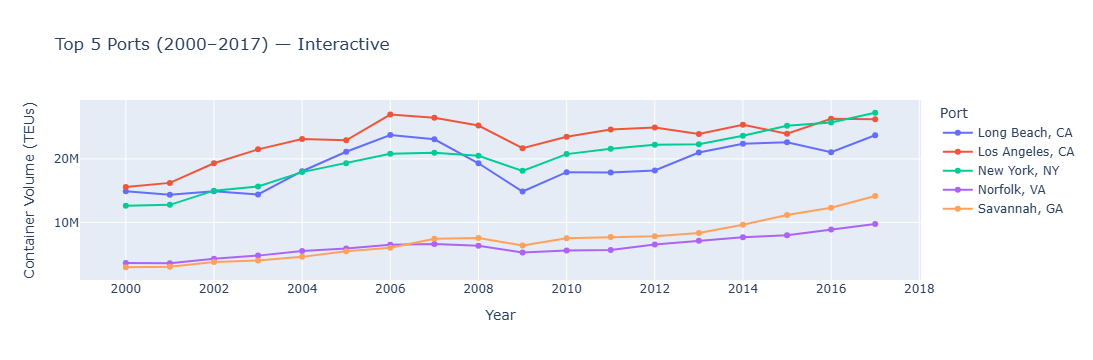

In [146]:
top_ports = (df_long.groupby("Port")["Volume"].mean().sort_values(ascending=False).head(5).index)
df_top = df_long[df_long["Port"].isin(top_ports)]
fig = px.line(df_top,x="Year", y="Volume", color="Port",markers=True, title="Top 5 Ports (2000–2017) — Interactive", hover_data={"Volume": ":,.0f", "Year": True})
fig.update_layout(xaxis_title="Year", yaxis_title="Container Volume (TEUs)", hovermode="x unified")
fig.write_html("top_5_ports_interactive.html")
fig.show()

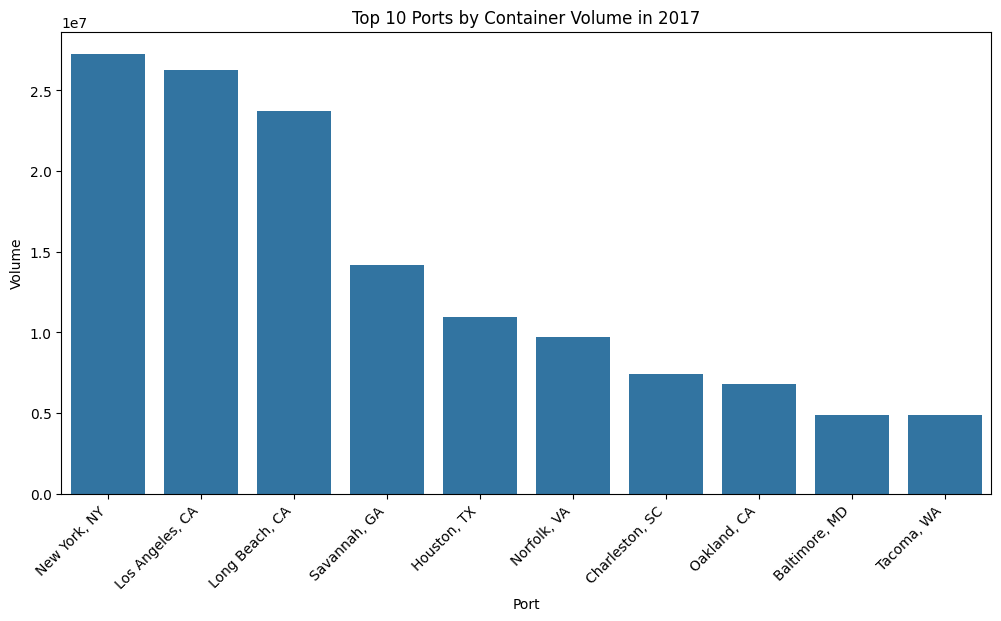

In [147]:
df_2017 = (df_long[df_long["Year"] == 2017].sort_values("Volume", ascending=False).head(10))
plt.figure(figsize=(12,6))
sns.barplot(data=df_2017, x="Port", y="Volume")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Ports by Container Volume in 2017")
plt.show()

In [148]:
top10 = (df_long.groupby("Port")["Volume"] .sum() .sort_values(ascending=False) .head(10) .index)

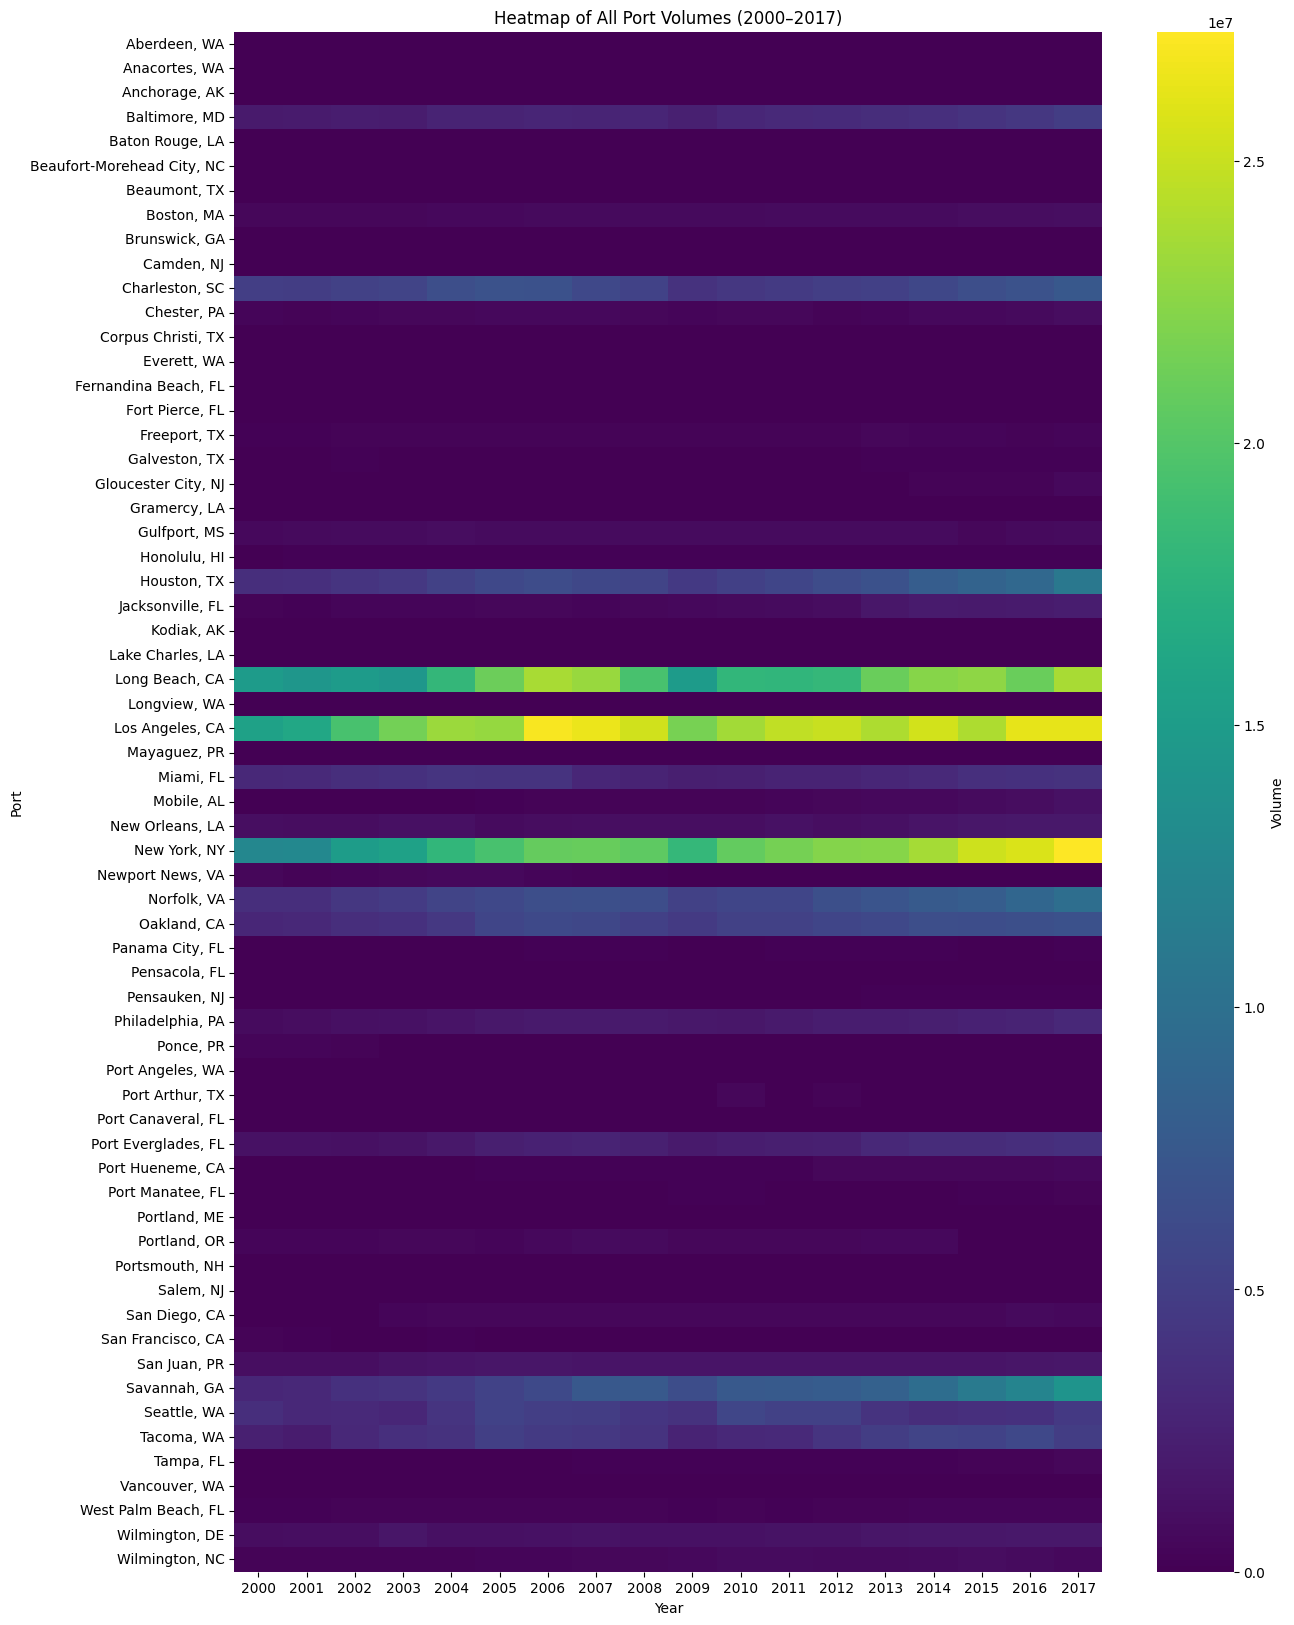

In [149]:
pivot = df_long.pivot(index="Port", columns="Year", values="Volume")
plt.figure(figsize=(14,20))
sns.heatmap(pivot, cmap="viridis", cbar_kws={'label': 'Volume'})
plt.title("Heatmap of All Port Volumes (2000–2017)")
plt.show()

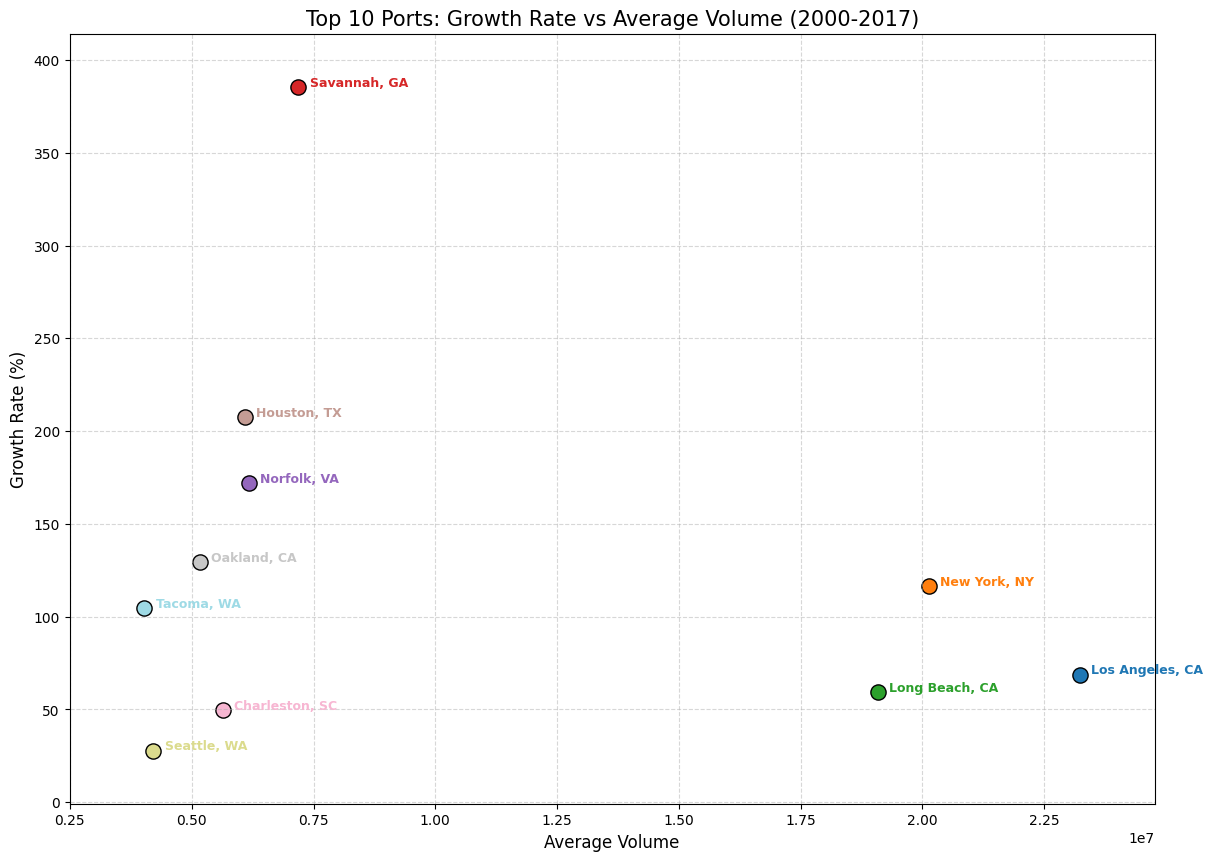

In [150]:
df_long.dropna(subset=["Volume"])
stats = df_long.groupby("Port")["Volume"].agg(["mean", "first", "last"])
stats = stats[stats["first"] > 0]
stats["growth_rate"] = (stats["last"] - stats["first"]) / stats["first"] * 100
stats = stats.replace([np.inf, -np.inf], np.nan).dropna()
stats = stats.loc[top10]
plt.figure(figsize=(14,10))
ports = stats.index
colors = plt.cm.tab20(np.linspace(0, 1, len(ports)))
for port, color in zip(ports, colors):
    x = stats.loc[port, "mean"]
    y = stats.loc[port, "growth_rate"]
    plt.scatter(x, y, color=color, s=120, edgecolor="black")
    plt.text(x + (stats["mean"].max() * 0.01), y + 0.5, port, fontsize=9, color=color, weight="bold")
plt.xlabel("Average Volume", fontsize=12)
plt.ylabel("Growth Rate (%)", fontsize=12)
plt.title("Top 10 Ports: Growth Rate vs Average Volume (2000-2017)", fontsize=15)
plt.grid(True, linestyle="--", alpha=0.5)
plt.margins(0.08)

<Figure size 1600x1000 with 0 Axes>

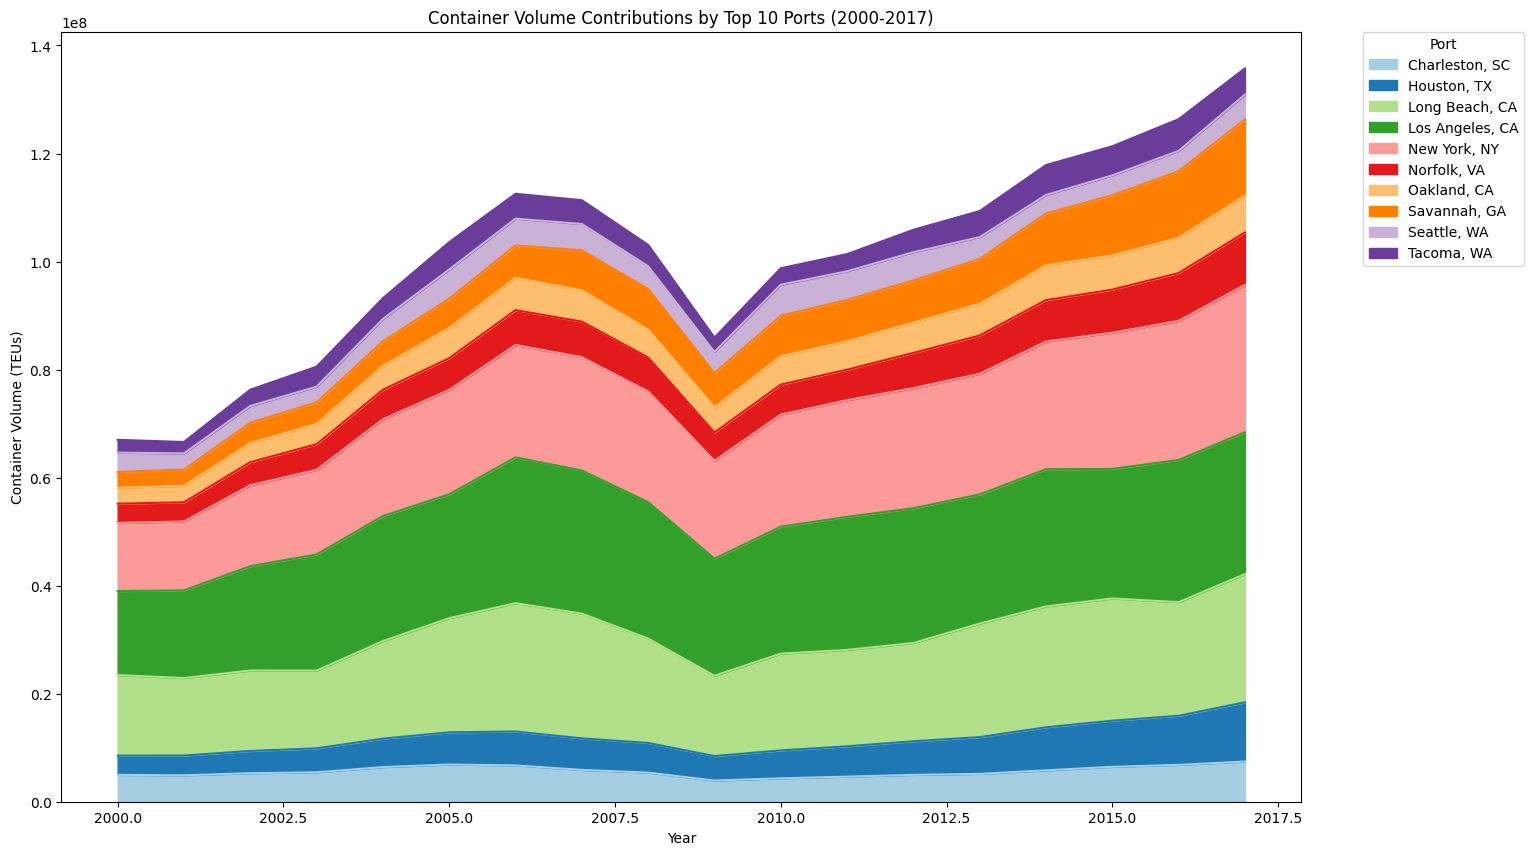

In [154]:
area = df_long[df_long["Port"].isin(top10)].pivot(index="Year", columns="Port", values="Volume")
colors = plt.cm.Paired(range(10))
plt.figure(figsize=(16,10))
area.plot(kind="area", stacked=True, figsize=(16,10), color=colors)
plt.title("Container Volume Contributions by Top 10 Ports (2000-2017)")
plt.xlabel("Year")
plt.ylabel("Container Volume (TEUs)")
plt.legend(title="Port", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.savefig("port_volume_area.png", dpi=300, bbox_inches="tight")
plt.show()